In [ ]:
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import numpy as np

IMAGE_WIDTH = 28
IMAGE_HEIGHT = 28

def __prepare_images(imgs, default_dims):
  if imgs.ndim == default_dims:
    imgs = imgs.reshape((*imgs.shape, 1))
  imgs = imgs.astype('float32') / 255.
  return imgs

def prepare_multiple_images(imgs):
  return __prepare_images(imgs, 3)

def prepare_single_images(imgs):
  return __prepare_images(imgs, 2)

(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()
x_train = prepare_multiple_images(x_train)
x_test = prepare_multiple_images(x_test)

11493376/11490434 [==============================] - 0s 0us/step


In [ ]:
classification_body = keras.Sequential([
  keras.layers.Conv2D(32, 2, padding='same', activation=tf.nn.relu, input_shape=(IMAGE_HEIGHT, IMAGE_WIDTH, 1)),
  keras.layers.Conv2D(32, 2, padding='same', activation=tf.nn.relu),
  keras.layers.MaxPool2D(2),
  keras.layers.Conv2D(64, 2, padding='same', activation=tf.nn.relu),
  keras.layers.Conv2D(128, 2, padding='same', activation=tf.nn.relu),
  keras.layers.MaxPool2D(2),
  keras.layers.Flatten(),
  keras.layers.Dense(20, activation=tf.nn.relu)
])

classification_head = keras.Sequential([
  keras.layers.Dense(10, activation=tf.nn.softmax)
])

classification_model = keras.Sequential([
  classification_body,
  classification_head
])

In [ ]:
classification_model.compile(
  optimizer=keras.optimizers.Adam(1e-3),
  loss=keras.losses.SparseCategoricalCrossentropy(),
  metrics=[
    keras.metrics.SparseCategoricalAccuracy('preciznost')
  ]
)

classification_model.fit(x_train, y_train, epochs=2)
classification_model.evaluate(x_test, y_test)

Epoch 1/2
1875/1875 [==============================] - 14s 7ms/step - loss: 0.1657 - preciznost: 0.9495
Epoch 2/2
313/313 [==============================] - 1s 4ms/step - loss: 0.0480 - preciznost: 0.9850


[0.04799741879105568, 0.9850000143051147]

In [ ]:
reconstruction_head = keras.Sequential([
  keras.layers.Dense(7 * 7 * 128, activation=tf.nn.tanh),
  keras.layers.Reshape((7, 7, 128)),
  #keras.layers.Conv2DTranspose(128, 2, strides=1, activation=tf.nn.tanh, padding='same'),
  keras.layers.Conv2DTranspose(64, 2, strides=2, activation=tf.nn.tanh),
  keras.layers.Conv2DTranspose(32, 2, strides=2, activation=tf.nn.tanh),
  keras.layers.Conv2D(1, 1, activation=tf.nn.tanh)
])

reconstruction_model = keras.Sequential([
  classification_body,
  reconstruction_head
])

reconstruction_forward_check_model = keras.Sequential([
  reconstruction_model, 
  classification_body
])

reconstruction_optimizer = keras.optimizers.Adam()

mse = keras.metrics.MeanSquaredError()

reconstruction_training_dataset = tf.data.Dataset.from_tensor_slices((x_train, x_train)).shuffle(1024).batch(32)

EPOCHS = 2

for epoch in range(EPOCHS):
  mse.reset_states()
  print(f'Epochs {epoch}')
  iter = 0
  for x, y in reconstruction_training_dataset:
    with tf.GradientTape() as tape:
      prediction = reconstruction_model(x, training=True)
      #original_mid_value = classification_body(x, training=False)
      #reconstructed_mid_value = reconstruction_forward_check_model(x, training=True)
      #original_logits = model(x, training=False)
      #reconstructed_logits = reconstruction_full_foward_check_model(x, training=True)
      loss = keras.losses.mean_squared_error(y, prediction)
      #loss = keras.losses.mean_squared_error(y, prediction) + keras.losses.mean_squared_error(original_mid_value, reconstructed_mid_value)
      #loss = keras.losses.mean_squared_error(original_mid_value, reconstructed_mid_value)
      #loss = keras.losses.mean_squared_error(y, prediction) + keras.losses.categorical_crossentropy(original_logits, reconstructed_logits)
      #loss = keras.losses.categorical_crossentropy(original_logits, reconstructed_logits)
    mse.update_state(y, prediction)
    gradients = tape.gradient(loss, reconstruction_head.trainable_variables)
    reconstruction_optimizer.apply_gradients(zip(gradients, reconstruction_head.trainable_variables))
    if iter % 500 == 0:
      print(f'  iter{iter} MSE: {mse.result().numpy()}')
    iter += 1

Epochs 0
  iter0 MSE: 0.1487494260072708
  iter500 MSE: 0.04918525740504265
  iter1000 MSE: 0.04628781974315643
  iter1500 MSE: 0.04460633173584938
Epochs 1
  iter0 MSE: 0.0405854806303978
  iter500 MSE: 0.03900614753365517
  iter1000 MSE: 0.03844723477959633
  iter1500 MSE: 0.03812836483120918


In [ ]:
def eval_model(reconstruction_model, classification_model, eval_data):
  if len(eval_data) != 2:
    raise Error(
        'Evaluacioni podaci moraju imati ulaz i labele, ovo nema odgovarajuce dimenzije!')
  x_eval, y_eval = eval_data
  print('|====| Evaluacija rekonstruktivnog modela |=====|')

  estimation_model = keras.Sequential([reconstruction_model, classification_model])
  estimation_model.compile(loss='sparse_categorical_crossentropy', metrics=['accuracy'])
  est_loss, est_acc = estimation_model.evaluate(x_eval, y_eval, verbose=0)
  print(f'  Loss pri klasifikaciji rekonstruisanih slika:{est_loss}\n  Preciznost pri klasifikaciji rekonstruisanih slika: {est_acc}')
  
  print('  -------------------')

  accuracy = keras.metrics.Accuracy()
  accuracy.reset_states()
  predicted_classes = classification_model(x_test).numpy().argmax(1)
  reconstructed_prediction = estimation_model(x_test).numpy().argmax(1)
  accuracy.update_state(predicted_classes, reconstructed_prediction)
  print(f'  Identicnost klasifikacije: {accuracy.result().numpy()}')

  print('  -------------------')
  
  eval_res = reconstruction_model.evaluate(x_eval, x_eval, verbose=0)
  print(f'  Loss modela za rekonstrukciju: {eval_res[0] if type(eval_res) is list else eval_res}')

  print('  -------------------')

  classification_loss, classification_acc = classification_model.evaluate(x_eval, y_eval, verbose=0)
  print(f'  Loss klasifikatora: {classification_loss}\n  Accuracy klasifikatora: {classification_acc}')

  print('|===============================================|')

reconstruction_model.compile(loss='mse', metrics=['mse'])
eval_model(reconstruction_model, classification_model, (x_test, y_test))

|====| Evaluacija rekonstruktivnog modela |=====|
  Loss pri klasifikaciji rekonstruisanih slika:0.10876984894275665
  Preciznost pri klasifikaciji rekonstruisanih slika: 0.965499997138977
  -------------------
  Identicnost klasifikacije: 0.9710999727249146
  -------------------
  Loss modela za rekonstrukciju: 0.03763636574149132
  -------------------
  Loss klasifikatora: 0.04799741879105568
  Accuracy klasifikatora: 0.9850000143051147
|===============================================|


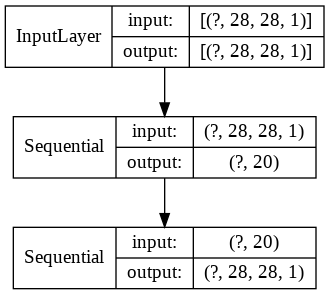

In [ ]:
keras.utils.plot_model(reconstruction_model, show_shapes=True, show_layer_names=False)

<Figure size 432x288 with 0 Axes>

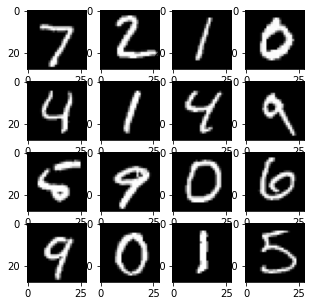

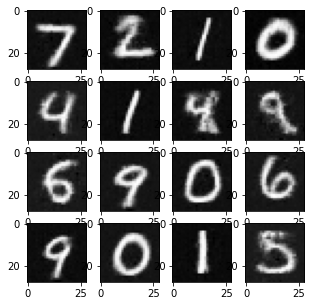

In [ ]:
PLOT_ROW = 4
PLOT_COL = 4

FIG_SIZE = 5

def fake_rgb_to_gray_scale(imgs):
  if imgs.shape[imgs.ndim - 1] == 1:
    imgs = imgs.reshape(imgs.shape[:imgs.ndim - 1])
  return imgs

def show_images(imgs, rows, cols, fig_size=FIG_SIZE):
  f, axs = plt.subplots(rows, cols)
  f.set_figheight(FIG_SIZE)
  f.set_figwidth(FIG_SIZE)
  for i, img in enumerate(fake_rgb_to_gray_scale(imgs)):
    axs[i // cols, i % cols].imshow(img)
  plt.show()

imgs = x_test[:PLOT_ROW * PLOT_COL]
reconstructed_imgs = reconstruction_model(imgs).numpy()

plt.gray()
show_images(imgs, PLOT_ROW, PLOT_COL)
show_images(reconstructed_imgs, PLOT_ROW, PLOT_COL)

In [ ]:
estimation_model = keras.Sequential([
  reconstruction_model,
  classification_model
])

estimation_model.compile(loss='sparse_categorical_crossentropy', metrics=['accuracy'])

accuracy = keras.metrics.Accuracy()

accuracy.reset_states()

predicted_classes = classification_model(x_test).numpy().argmax(1)
reconstructed_prediction = estimation_model(x_test).numpy().argmax(1)

accuracy.update_state(predicted_classes, reconstructed_prediction)

print(f'Accuracy: {accuracy.result().numpy()}')

classification_model.evaluate(x_test, y_test)
estimation_model.evaluate(x_test, y_test)

Accuracy: 0.9732000231742859
313/313 [==============================] - 1s 3ms/step - loss: 0.1047 - accuracy: 0.9669


[0.10465873032808304, 0.9668999910354614]